In [1]:
# train a decision tree on the iris dataset
from sklearn.datasets import load_iris
from sklearn.tree import DecisionTreeClassifier

iris = load_iris(as_frame=True)
X_iris = iris.data[["petal length (cm)", "petal width (cm)"]].values
y_iris = iris.target

tree_clf = DecisionTreeClassifier(max_depth=2)
tree_clf.fit(X_iris, y_iris)

DecisionTreeClassifier(max_depth=2)

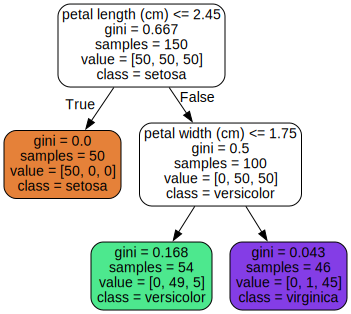

In [2]:
# visualize it
from sklearn.tree import export_graphviz
from graphviz import Source

export_graphviz(
    tree_clf,
    out_file="iris_tree.dot",
    feature_names=["petal length (cm)", "petal width (cm)"],
    class_names=iris.target_names,
    rounded=True,
    filled=True
)

Source.from_file("iris_tree.dot")

In [3]:
# test regularization on the moons dataset
from sklearn.datasets import make_moons

X_moons, y_moons = make_moons(n_samples=150, noise=0.2, random_state=0)

tree_clf1 = DecisionTreeClassifier()
tree_clf2 = DecisionTreeClassifier(min_samples_leaf=3)
tree_clf1.fit(X_moons, y_moons)
tree_clf2.fit(X_moons, y_moons)

DecisionTreeClassifier(min_samples_leaf=3)

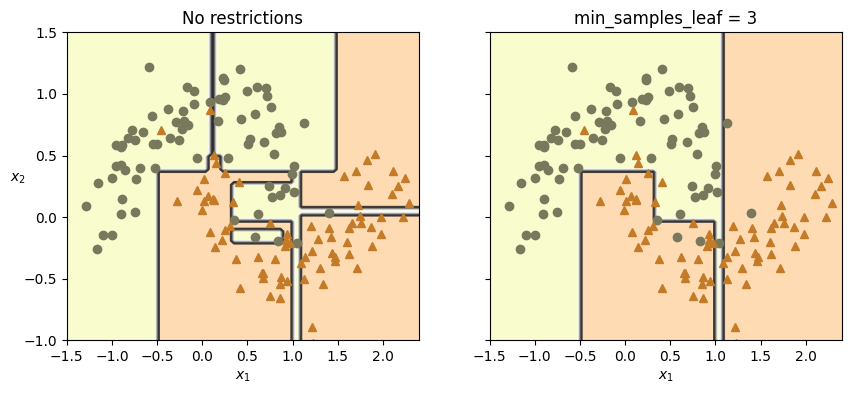

In [4]:
# visualize it
import matplotlib.pyplot as plt
import numpy as np

def plot_decision_boundary(clf, X, y, axes, cmap):
    x1, x2 = np.meshgrid(np.linspace(axes[0], axes[1], 100),
                         np.linspace(axes[2], axes[3], 100))
    X_new = np.c_[x1.ravel(), x2.ravel()]
    y_pred = clf.predict(X_new).reshape(x1.shape)
    
    plt.contourf(x1, x2, y_pred, alpha=0.3, cmap=cmap)
    plt.contour(x1, x2, y_pred, cmap="Greys", alpha=0.8)
    colors = {"Wistia": ["#78785c", "#c47b27"], "Pastel1": ["red", "blue"]}
    markers = ("o", "^")
    for idx in (0, 1):
        plt.plot(X[:, 0][y == idx], X[:, 1][y == idx],
                 color=colors[cmap][idx], marker=markers[idx], linestyle="none")
    plt.axis(axes)
    plt.xlabel(r"$x_1$")
    plt.ylabel(r"$x_2$", rotation=0)

fig, axes = plt.subplots(ncols=2, figsize=(10, 4), sharey=True)
plt.sca(axes[0])
plot_decision_boundary(tree_clf1, X_moons, y_moons,
                       axes=[-1.5, 2.4, -1, 1.5], cmap="Wistia")
plt.title("No restrictions")
plt.sca(axes[1])
plot_decision_boundary(tree_clf2, X_moons, y_moons,
                       axes=[-1.5, 2.4, -1, 1.5], cmap="Wistia")
plt.title(f"min_samples_leaf = {tree_clf2.min_samples_leaf}")
plt.ylabel("")
plt.show()

In [5]:
# clf1 looks overfit, check on a test set
X_moons_test, y_moons_test = make_moons(n_samples=1500, noise=0.2, random_state=0)
tree_clf1.score(X_moons_test, y_moons_test), tree_clf2.score(X_moons_test, y_moons_test)

(0.8886666666666667, 0.916)

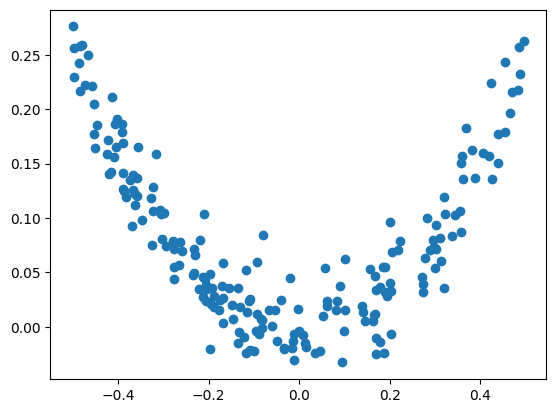

In [6]:
# regression with decision trees
X_quad = np.random.rand(200, 1) - 0.5
y_quad = X_quad ** 2 + 0.025 * np.random.randn(200, 1)

plt.scatter(X_quad, y_quad)
plt.show()

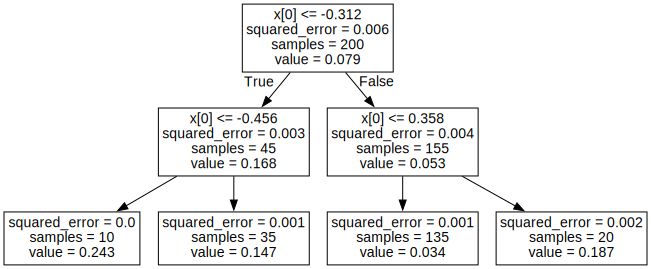

In [7]:
from sklearn.tree import DecisionTreeRegressor

tree_reg = DecisionTreeRegressor(max_depth=2)
tree_reg.fit(X_quad, y_quad)

export_graphviz(tree_reg, out_file="tree_reg.dot")
Source.from_file("tree_reg.dot")

In [10]:
# rotating data with PCA transformation before applying decision tree
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

pca_pipeline = make_pipeline(StandardScaler(), PCA())
X_iris_rotated = pca_pipeline.fit_transform(X_iris)
tree_clf_pca = DecisionTreeClassifier(max_depth=2)
tree_clf_pca.fit(X_iris_rotated, y_iris)


DecisionTreeClassifier(max_depth=2)

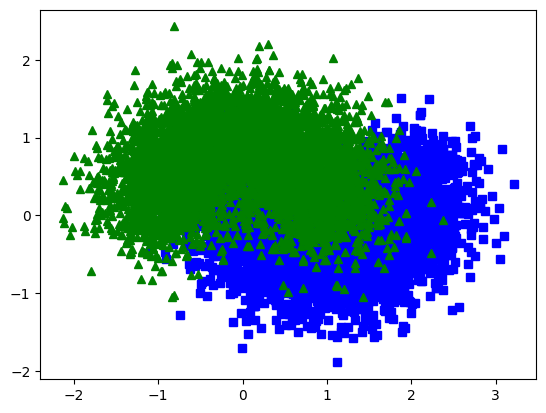

In [24]:
# make a forest
# first train decision tree for make_moons
X, y = make_moons(n_samples=10000, noise=0.4, random_state=0)

plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bs")
plt.plot(X[:, 0][y==0], X[:, 1][y==0], "g^")
plt.show()

In [28]:
# train a decision tree classifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)
clf = DecisionTreeClassifier(random_state=0)

params = {
    'max_leaf_nodes': [None, 50, 30, 10, 5], 
    'criterion': ['gini', 'entropy'],
    'max_depth': [2,4,6,8,10,12]
}

clf_gs = GridSearchCV(clf, params)
clf_gs.fit(X, y)

clf_gs.best_params_

GridSearchCV(estimator=DecisionTreeClassifier(random_state=0),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [2, 4, 6, 8, 10, 12],
                         'max_leaf_nodes': [None, 50, 30, 10, 5]})

In [33]:
# check its accuracy
from sklearn.metrics import accuracy_score

y_pred = clf_gs.best_estimator_.predict(X_test)
accuracy_score(y_test, y_pred)

0.872

In [57]:
# now grow a forest
from sklearn.model_selection import ShuffleSplit

forest = [DecisionTreeClassifier(**clf_gs.best_params_) for _ in range(1000)]
forest_preds = np.zeros(shape=(1000, len(y_test)))

ss = ShuffleSplit(n_splits=1000, train_size=0.1)
for i, (train_index, test_index) in enumerate(ss.split(X_train)):
    forest[i].fit(X_train[train_index], y_train[train_index])
    forest_preds[i] = forest[i].predict(X_test)

forest_preds


array([[0., 0., 0., ..., 1., 1., 0.],
       [1., 0., 0., ..., 1., 1., 0.],
       [1., 0., 0., ..., 1., 1., 0.],
       ...,
       [1., 0., 0., ..., 1., 1., 0.],
       [1., 0., 0., ..., 1., 1., 0.],
       [1., 0., 0., ..., 1., 0., 0.]])

In [78]:
# check the score
from scipy.stats import mode
forest_pred = mode(forest_preds, axis=0, keepdims=True).mode[0]

accuracy_score(forest_pred, y_test)

0.8744